# Fit emimTF2N data

EoS: PR

Parameter T dependence: Constant

N (total fitting parameters): 2

## Import Functions

In [1]:
import idaes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import sys
sys.path.append('../../../')

from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)
from pyomo.opt import TerminationCondition, SolverStatus

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom

# parmest (binary_param2)
from bip_fitting_functions import constant

import scipy.stats as stats

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches

## Load Data

In [2]:
data_full = pd.read_csv('../r32_emimtf2n_full.csv')
data_subset = pd.read_csv('../r32_emimtf2n_subset.csv')
data_extended = pd.read_csv('r32-emimtf2n-extended.csv')

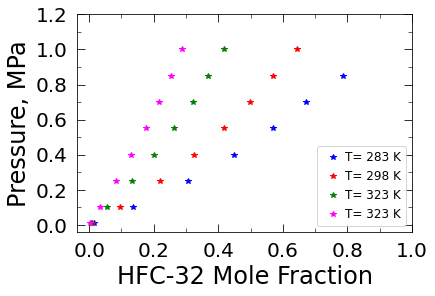

In [3]:
fig, ax = plt.subplots()

ax.plot(data_full["x_R32"][:7],data_full["pressure"][:7]/1e6,"*",color='blue',label="T= 283 K")
ax.plot(data_full["x_R32"][7:15],data_full["pressure"][7:15]/1e6,"*",color='red',label="T= 298 K")
ax.plot(data_full["x_R32"][15:23],data_full["pressure"][15:23]/1e6,"*",color='green',label="T= 323 K")
ax.plot(data_full["x_R32"][23:],data_full["pressure"][23:]/1e6,"*",color='magenta',label="T= 323 K")

# plt.title('Isotherm R32-[emim][TF2N]')
ax.set_ylabel('Pressure, MPa',fontsize=24)
ax.set_xlabel('HFC-32 Mole Fraction',fontsize=24)

ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9],minor=True)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9, 1.1],minor=True)

ax.tick_params("both", direction="in", which="both", length=4, labelsize=20, pad=10)
ax.tick_params("both", which="major", length=8)
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.legend(fontsize=12, handletextpad=0.00, loc="lower right")#, bbox_to_anchor=(1, 0.5))
fig.savefig('R32-emimTF2N-data.pdf',bbox_inches='tight')
plt.show()

## Load Configuration + Check DOF + Load Parameters

In [4]:
lhs_results1 = pd.read_csv('../Data/Fits/LHS_Fits/PR_noTdep_LHS.csv',index_col=0)
lhs_results1 = lhs_results1[['sc_param1','sc_param2','SSR']]
lhs_results2 = pd.read_csv('Data/Init_Final/LHS_Output/PR_noTdep_LHS_final.csv',index_col=0)
lhs_results2 = lhs_results2[['sc_param1','sc_param2','SSR']]
lhs_results = pd.concat([lhs_results1,lhs_results2],axis=0).reset_index(drop=True)

In [5]:
lhs_results.dropna(axis=0)

,sc_param1,sc_param2,SSR
51,-0.217418,-0.082728,0.652664
78,-0.294291,-0.085820,0.652664
664,-0.545594,-0.077784,0.870525
688,0.690192,0.057419,11.445208
825,0.071151,0.025815,12.154741
957,-0.280031,-0.064855,0.652664
1958,0.536221,0.060693,11.616880
2229,-0.417981,-0.059876,2.755627
2572,-0.349454,-0.074959,0.652664
2683,0.284756,0.047869,12.052790


In [6]:
lhs_best = lhs_results[lhs_results.SSR == lhs_results.SSR.min()]
lhs_best

,sc_param1,sc_param2,SSR
78,-0.294291,-0.08582,0.652664


In [7]:
sc_param1 = lhs_results.at[78, 'sc_param1']
sc_param2 = lhs_results.at[78, 'sc_param2']

In [8]:
from hfc32_emimtf2n_PR import configuration 

In [9]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

The initial DOF is 7


## Fit Parameters

## Apply Parameters + Plot

In [10]:
parameters, obj_value, a = constant(data_subset, configuration, 'R32', 'emimTf2N', "x_R32", "x_emimTf2N", 
        init_temp =  283.1, init_press =   399300 , init_x_c1 =    0.448, init_x_c2 = 0.552,
        init_kappa_A_2_1 = sc_param1, init_kappa_A_1_2 = sc_param2, 
        eps = 0.1, scaling_fac = 1e-9 , read=False, 
        filename='Data/Fits/Ipopt_Output/PR_noTdep_final.txt')

2022-10-13 16:43:39 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-10-13 16:43:39 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-10-13 16:43:39 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-10-13 16:43:40 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-10-13 16:43:40 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-10-13 16:43:41 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-10-13 16:43:41 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-10-13 16:43:42 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-10-13 16:43:42 [INFO] idaes

/Users/bridgettebefort/opt/anaconda3/envs/idaes-pse-dev/lib/python3.9/site-packages/pyomo/contrib/interior_point/interface.py:418: RuntimeWarning: divide by zero encountered in true_divide
  data = (duals_primals_lb/(primals - self._nlp.primals_lb()) +


In [11]:
print('Objective (SSE):',obj_value)

Objective (SSE): 0.6526637302427074


In [12]:
print('Parameters:',parameters)

Parameters: fs.properties.PR_kappa_A[emimTf2N,R32]   -0.200947
fs.properties.PR_kappa_A[R32,emimTf2N]   -0.056196
dtype: float64


In [13]:
params2save = np.zeros(8)
params2save[0] = parameters[1]
params2save[1] = parameters[0]

In [14]:
np.savetxt('Data/Fits/PR_params_noTdep.csv',params2save,delimiter=',')

In [15]:
cov = np.array(a)
print('Covariance Matrix:')
print(cov)

Covariance Matrix:
[[3.66990409e-04 3.31181344e-05]
 [3.31181344e-05 4.59347392e-06]]


In [16]:
np.savetxt('Data/Covariance/PR_Cov_noTdep.csv',cov,delimiter=',')

## Apply Parameters + Plot

In [17]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [18]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

m.fs.properties.PR_kappa_A['R32','emimTf2N'] = parameters['fs.properties.PR_kappa_A[R32,emimTf2N]']
m.fs.properties.PR_kappa_A['emimTf2N','R32'] = parameters['fs.properties.PR_kappa_A[emimTf2N,R32]']

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

R32_x = np.zeros((len(data_extended)))
P = np.zeros((len(data_extended)))
T = np.zeros((len(data_extended)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

for i in range(len(data_extended)):
    print('i:',i)
    print('Try x_IL:',data_extended["x_emimTf2N"].iloc[i])
    m.fs.liq = data_extended["x_emimTf2N"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data_extended["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data_extended["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data_extended["x_R32"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data_extended["x_R32"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data_extended["temperature"].iloc[i]))
    
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        
    except:
        print('Initialization Error')
        
    try:
        
        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
            print('Feasible/Optimal Solution')
            R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])
            T[i] = data_extended["temperature"].iloc[i]
        else:
            print('Infeasible Solution')
            R32_x[i] = np.nan
            P[i] = np.nan
            T[i] = data_extended["temperature"].iloc[i]

    except ValueError:
        R32_x[i] = np.nan
        P[i] = np.nan
        T[i] = data_extended["temperature"].iloc[i]
        print('Solver Error')

i: 0
Try x_IL: 0.975
Feasible/Optimal Solution
i: 1
Try x_IL: 0.95
Feasible/Optimal Solution
i: 2
Try x_IL: 0.925
Feasible/Optimal Solution
i: 3
Try x_IL: 0.9
Feasible/Optimal Solution
i: 4
Try x_IL: 0.875
Feasible/Optimal Solution
i: 5
Try x_IL: 0.864
Feasible/Optimal Solution
i: 6
Try x_IL: 0.85
Feasible/Optimal Solution
i: 7
Try x_IL: 0.825
Feasible/Optimal Solution
i: 8
Try x_IL: 0.8
Feasible/Optimal Solution
i: 9
Try x_IL: 0.775
Feasible/Optimal Solution
i: 10
Try x_IL: 0.75
Feasible/Optimal Solution
i: 11
Try x_IL: 0.725
Feasible/Optimal Solution
i: 12
Try x_IL: 0.7
Feasible/Optimal Solution
i: 13
Try x_IL: 0.694
Feasible/Optimal Solution
i: 14
Try x_IL: 0.675
Feasible/Optimal Solution
i: 15
Try x_IL: 0.65
Feasible/Optimal Solution
i: 16
Try x_IL: 0.625
Feasible/Optimal Solution
i: 17
Try x_IL: 0.6
Feasible/Optimal Solution
i: 18
Try x_IL: 0.575
Feasible/Optimal Solution
i: 19
Try x_IL: 0.552
Feasible/Optimal Solution
i: 20
Try x_IL: 0.55
Feasible/Optimal Solution
i: 21
Try x_IL:

In [19]:
fitted_data = pd.DataFrame(data=[R32_x,P/1e6,T])
fitted_data = fitted_data.T
fitted_data.columns = ['R32_x','P, MPa','T, K']
fitted_data.to_csv('Data/Fits/PR_FittedData_noTdep.csv')

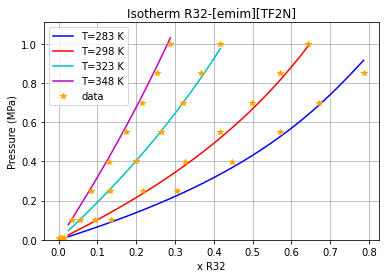

In [20]:
plt.plot(fitted_data.where(fitted_data['T, K']==283.15)['R32_x'],fitted_data.where(fitted_data['T, K']==283.15)['P, MPa'],"b-",label='T=283 K')
plt.plot(fitted_data.where(fitted_data['T, K']==298.15)['R32_x'],fitted_data.where(fitted_data['T, K']==298.15)['P, MPa'],"r-",label='T=298 K')
plt.plot(fitted_data.where(fitted_data['T, K']==323.15)['R32_x'],fitted_data.where(fitted_data['T, K']==323.15)['P, MPa'],"c-",label='T=323 K')
plt.plot(fitted_data.where(fitted_data['T, K']==348.05)['R32_x'],fitted_data.where(fitted_data['T, K']==348.05)['P, MPa'],"m-",label='T=348 K')
plt.plot(data_full["x_R32"],data_full["pressure"]/1e6,"*",color='orange',label="data")  
plt.title('Isotherm R32-[emim][TF2N]')
plt.ylabel('Pressure (MPa)')
plt.xlabel('x R32')
plt.grid(True)
plt.ylim(0,1.110000)
plt.legend()
plt.show()

### Print Eigvals, Eigvectors of Covariance

An identifiability analysis can be performed with these as well as a FIM because the covariance matrix is the inverse of the FIM. That means that if there are any eigvals >> 0, their eigvecs indicate directions of un-identifiability.

In [21]:
eigvals, eigvecs = np.linalg.eig(cov)

In [22]:
eigvals

array([3.69992092e-04, 1.59179092e-06])

In [23]:
eigvecs

array([[ 0.99591773, -0.09026563],
       [ 0.09026563,  0.99591773]])

In [ ]:
np.savetxt('Data/EigenAnalysis/PR_vals_noTdep.csv',eigvals,delimiter=',')
np.savetxt('Data/EigenAnalysis/PR_vecs_noTdep.csv',eigvecs,delimiter=',')

In [ ]:
FIM = np.linalg.inv(cov) 

#A_opt
FIM_trace = np.trace(FIM)
cov_trace = np.trace(cov)

#D_opt
FIM_det = np.linalg.det(FIM)

#E_opt
eigvals_FIM, eigvecs_FIM = np.linalg.eig(FIM)
eigvals_FIM_min = eigvals_FIM.min()
eigvals_FIM_max = eigvals_FIM.max()

np.savetxt('Data/EigenAnalysis/PR_FIMtrdet_noTdep.csv',[cov_trace,FIM_trace,FIM_det,eigvals_FIM_min,eigvals_FIM_max])
np.savetxt('Data/EigenAnalysis/PR_FIMvals_noTdep.csv',eigvals_FIM,delimiter=',')
np.savetxt('Data/EigenAnalysis/PR_FIMvecs_noTdep.csv',eigvecs_FIM,delimiter=',')

## AIC Value

See: https://doi.org/10.1080/21642583.2018.1496042

AIC(k) = Nln(MSE(k))+2k

N: number of data points

MSE(k): mean squared error of the model with k parameters

k: number of parameters

MSE(k) = SSE(k)/N

SSE: sum of squared error of the model with k parameters

In [ ]:
#number of datapoints
N = len(data_subset)
#MSE(k)
MSE = obj_value/N
#number of parameters
k = 2

In [ ]:
AIC = N*np.log(MSE) + 2*k
AIC

In [ ]:
AIC_data = pd.DataFrame(data=[N,MSE,k,obj_value,AIC])
AIC_data = AIC_data.T
AIC_data.columns = ['N','MSE','k','Objective, Pa^2','AIC']
AIC_data.to_csv('Data/AIC/PR_AIC_noTdep.csv')